<a href="https://colab.research.google.com/github/hettiepath/pis_study/blob/master/dl-medical-imaging/reference/malaria_PeerJ2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from https://lhncbc.nlm.nih.gov/publication/pub9932

### NIH 데이터 논문(2018)
- https://lhncbc.nlm.nih.gov/system/files/pub9752.pdf
- https://peerj.com/articles/4568/
- https://peerj.com/articles/4568/#supplemental-information

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
%%shell
pwd
cd '/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/reference/revised_code(2018)'
cd malaria/
pwd

/content
/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/reference/revised_code(2018)/malaria


In [ ]:
# %%shell
# pwd
# cd '/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/reference/revised_code(2018)'
# rm -rf malaria/
# mkdir malaria/
# cd malaria/
# pwd
# wget ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
# unzip cell_images.zip
# wget ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/malaria_cell_classification_code.zip
# unzip malaria_cell_classification_code.zip
# wget ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/patientid_cellmapping_parasitized.csv
# wget ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/patientid_cellmapping_uninfected.csv

tree 를 통한 프로젝트 구조 살펴보기

In [ ]:
%%shell
sudo apt-get install tree # for Ubuntu
# cd '/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/reference/revised_code(2018)/malaria'
# tree --dirsfirst --filelimit 10

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


## load_data.py

In [ ]:
############Load libraries#####################################################
import cv2
import numpy as np
import os
from keras.utils import np_utils
###############################################################################
#cross-validation at the patient level
origin_path = '/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/reference/revised_code(2018)/'
ORIG_INPUT_DATASET = origin_path + 'malaria/cell_images'
train_data_dir = origin_path + 'malaria/train'
valid_data_dir = origin_path + 'malaria/valid'
test_data_dir = origin_path + 'malaria/test'
###############################################################################
# declare the number of samples in each category
TRAIN_SPLIT = 0.8 #  training samples
VAL_SPLIT = 0.1 #  validation samples
num_classes = 2
img_rows_orig = 100
img_cols_orig = 100

Using TensorFlow backend.


이미지 경로를 학습, 검증 및 테스트로 분할
- 모든 예제 이미지의 경로를 잡고 무작위로 섞음
- 세 개의 새 하위 디렉터리 생성 (training, validation, testing) 해서 이미지를 해당 디렉토리에 자동으로 복사

In [ ]:
# import the necessary packages
from imutils import paths
import random
import shutil
import os

# 모든 예제 이미지의 경로를 잡고 무작위로 섞음
# grab the paths to all input images in the original input directory and shuffle them
imagePaths = list(paths.list_images(ORIG_INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)

# compute the training and testing split
nb_train_samples = int(len(imagePaths) * TRAIN_SPLIT)
nb_test_samples = len(imagePaths) - nb_train_samples
trainPaths = imagePaths[:nb_train_samples]
testPaths = imagePaths[nb_train_samples:]

# we'll be using part of the training data for validation
i = int(len(trainPaths) * VAL_SPLIT)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]

추출 : 파일 이름 + 라벨
- 필요한 경우 하위 디렉토리 생성
- 실제 이미지 파일 자체를 하위 디렉토리에 복사

In [ ]:
# 우리가 구축 할 데이터 세트 정의
# define the datasets that we'll be building
datasets = [
	("training", trainPaths, train_data_dir),
	("validation", valPaths, valid_data_dir),
  ("testing", testPaths, test_data_dir)
]

In [ ]:
# %%shell
# pwd
# cd '/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/reference/revised_code(2018)/malaria'
# rm -rf train/
# rm -rf valid/
# rm -rf test/
# ls

In [ ]:
# # loop over the datasets
# for (dType, imagePaths, baseOutput) in datasets:
#   # 생성중인 데이터 분할 표시
# 	# show which data split we are creating
# 	print("[INFO] building '{}' split".format(dType))

#   # 기본 출력 디렉토리가 존재하지 않으면 생성
# 	# if the output base output directory does not exist, create it
# 	if not os.path.exists(baseOutput):
# 		print("[INFO] 'creating {}' directory".format(baseOutput))
# 		os.makedirs(baseOutput)

#   # 입력 이미지 경로에 대한 루프
# 	# loop over the input image paths
# 	for inputPath in imagePaths:
#     # 입력 이미지의 파일 이름과 함께 해당 클래스 레이블 추출
# 		# extract the filename of the input image along with its corresponding class label
# 		filename = inputPath.split(os.path.sep)[-1]
# 		label = inputPath.split(os.path.sep)[-2]

#     # 레이블 디렉토리 경로 생성
# 		# build the path to the label directory
# 		labelPath = os.path.sep.join([baseOutput, label])

#     # 라벨 출력 디렉토리가 존재하지 않는 경우 생성
# 		# if the label output directory does not exist, create it
# 		if not os.path.exists(labelPath):
# 			print("[INFO] 'creating {}' directory".format(labelPath))
# 			os.makedirs(labelPath)

#     # 대상 이미지의 경로를 구성한 다음 이미지 자체를 복사
# 		# construct the path to the destination image and then copy the image itself
# 		p = os.path.sep.join([labelPath, filename])
# 		shutil.copy2(inputPath, p)

tree 를 통한 프로젝트 구조 다시 한 번 살펴보기

In [ ]:
%%shell
cd '/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/reference/revised_code(2018)/malaria'
tree --dirsfirst --filelimit 10

.
├── cell_images
│   ├── Parasitized [13780 entries exceeds filelimit, not opening dir]
│   └── Uninfected [13780 entries exceeds filelimit, not opening dir]
├── malaria_cell_classification_code
│   ├── custom_layers
│   │   ├── googlenet_custom_layers.py
│   │   ├── __init__.py
│   │   └── scale_layer.py
│   ├── custom_model.py
│   ├── densenet121_models.py
│   ├── evaluation.py
│   ├── feature_extraction.py
│   ├── load_data.py
│   └── readme.txt
├── test
│   ├── Parasitized [2726 entries exceeds filelimit, not opening dir]
│   └── Uninfected [2786 entries exceeds filelimit, not opening dir]
├── train
│   ├── Parasitized [9955 entries exceeds filelimit, not opening dir]
│   └── Uninfected [9887 entries exceeds filelimit, not opening dir]
├── valid
│   ├── Parasitized [1098 entries exceeds filelimit, not opening dir]
│   └── Uninfected [1106 entries exceeds filelimit, not opening dir]
├── cell_images.zip
├── malaria_cell_classification_code.zip
├── patientid_cellmapping_parasitized.c

### 데이터셋의 이미지 파일 및 라벨 확인해보기

In [ ]:
from PIL import Image

Parasitized


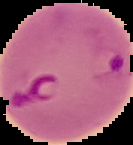

In [ ]:
print(trainPaths[0].split(os.path.sep)[-2])
Image.open(trainPaths[0])

training
C207ThinF_IMG_20151029_144152_cell_73.png
Uninfected


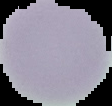

In [ ]:
print(datasets[0][0])
print(datasets[0][1][1].split(os.path.sep)[-1])
print(datasets[0][1][1].split(os.path.sep)[-2])
Image.open(datasets[0][1][1])

validation
C48P9thinF_IMG_20150721_162732_cell_1.png
Parasitized


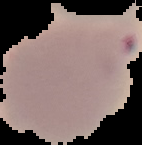

In [ ]:
print(datasets[1][0])
print(datasets[1][1][1].split(os.path.sep)[-1])
print(datasets[1][1][1].split(os.path.sep)[-2])
Image.open(datasets[1][1][1])

testing
C184P145ThinF_IMG_20151203_104440_cell_10.png
Parasitized


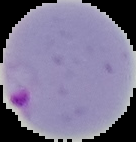

In [ ]:
print(datasets[2][0])
print(datasets[2][1][1].split(os.path.sep)[-1])
print(datasets[2][1][1].split(os.path.sep)[-2])
Image.open(datasets[2][1][1])

### 이미지 loading 함수 정의

In [ ]:
def load_training_data(img_rows=img_rows_orig,img_cols=img_cols_orig):
    # Load training images
    labels = os.listdir(train_data_dir)
    total = len(labels)
    
    X_train = np.ndarray((nb_train_samples, img_rows_orig, img_cols_orig, 3), dtype=np.uint8)
    Y_train = np.zeros((nb_train_samples,), dtype='uint8')
    

    i = 0
    print('-'*30)
    print('Creating training images...')
    print('-'*30)
    j = 0
    for label in labels:
        image_names_train = os.listdir(os.path.join(train_data_dir, label))
        total = len(image_names_train)
        print(label, total)
        for image_name in image_names_train:
            img = cv2.imread(os.path.join(train_data_dir, label, image_name), cv2.IMREAD_COLOR)
            img = np.array([cv2.resize(img, (img_rows,img_cols))])
            X_train[i] = img
            Y_train[i] = j

            if i % 100 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1
        i=0
        j += 1    
    print(i)                
    print('Loading done.')
    
    print('Transform targets to keras compatible format.')
    Y_train = np_utils.to_categorical(Y_train[:nb_train_samples], num_classes)

    np.save('imgs_train.npy', X_train, Y_train)
    return X_train, Y_train

In [ ]:
# load_training_data()

In [ ]:
def load_validation_data(img_rows=img_rows_orig,img_cols=img_cols_orig):
    # Load validation images
    labels = os.listdir(valid_data_dir)
    

    X_valid = np.ndarray((len(valPaths), img_rows_orig, img_cols_orig, 3), dtype=np.uint8)
    Y_valid = np.zeros((len(valPaths),), dtype='uint8')

    i = 0
    print('-'*30)
    print('Creating validation images...')
    print('-'*30)
    j = 0
    for label in labels:
        image_names_valid = os.listdir(os.path.join(valid_data_dir, label))
        total = len(image_names_valid)
        print(label, total)
        for image_name in image_names_valid:
            img = cv2.imread(os.path.join(valid_data_dir, label, image_name), cv2.IMREAD_COLOR)
            img = np.array([cv2.resize(img, (img_rows,img_cols))])

            X_valid[i] = img
            Y_valid[i] = j

            if i % 100 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1
        i = 0
        j += 1
    print(i)            
    print('Loading done.')
    
    print('Transform targets to keras compatible format.');
    Y_valid = np_utils.to_categorical(Y_valid[:len(valPaths)], num_classes)

    np.save('imgs_valid.npy', X_valid, Y_valid)
    
    return X_valid, Y_valid

In [ ]:
# load_validation_data()

In [ ]:
def load_test_data(img_rows=img_rows_orig,img_cols=img_cols_orig):
    # Load test images
    labels = os.listdir(test_data_dir)
    

    X_test = np.ndarray((nb_test_samples, img_rows_orig, img_cols_orig, 3), dtype=np.uint8)
    Y_test = np.zeros((nb_test_samples,), dtype='uint8')

    i = 0
    print('-'*30)
    print('Creating test images...')
    print('-'*30)
    j = 0
    for label in labels:
        image_names_test = os.listdir(os.path.join(test_data_dir, label))
        total = len(image_names_test)
        print(label, total)
        for image_name in image_names_test:
            img = cv2.imread(os.path.join(test_data_dir, label, image_name), cv2.IMREAD_COLOR)
            img = np.array([cv2.resize(img, (img_rows,img_cols))])

            X_test[i] = img
            Y_test[i] = j

            if i % 100 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1
        i = 0
        j += 1
    print(i)            
    print('Loading done.')
    
    print('Transform targets to keras compatible format.');
    Y_test = np_utils.to_categorical(Y_test[:nb_test_samples], num_classes)

    np.save('imgs_valid.npy', X_test, Y_test)
    
    return X_test, Y_test

In [ ]:
# load_test_data()

------------------------------
Creating test images...
------------------------------
Parasitized 2726
Done: 0/2726 images
Done: 100/2726 images
Done: 200/2726 images
Done: 300/2726 images
Done: 400/2726 images
Done: 500/2726 images
Done: 600/2726 images
Done: 700/2726 images
Done: 800/2726 images
Done: 900/2726 images
Done: 1000/2726 images
Done: 1100/2726 images
Done: 1200/2726 images
Done: 1300/2726 images
Done: 1400/2726 images
Done: 1500/2726 images
Done: 1600/2726 images
Done: 1700/2726 images
Done: 1800/2726 images
Done: 1900/2726 images
Done: 2000/2726 images
Done: 2100/2726 images
Done: 2200/2726 images
Done: 2300/2726 images
Done: 2400/2726 images
Done: 2500/2726 images
Done: 2600/2726 images
Done: 2700/2726 images
Uninfected 2786
Done: 0/2786 images
Done: 100/2786 images
Done: 200/2786 images
Done: 300/2786 images
Done: 400/2786 images
Done: 500/2786 images
Done: 600/2786 images
Done: 700/2786 images
Done: 800/2786 images
Done: 900/2786 images
Done: 1000/2786 images
Done: 11

(array([[[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         ...,
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],
 
 
        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0

## scale_layer.py

In [ ]:
from keras.layers import Layer
from keras.engine import InputSpec
from keras import backend as K
try:
    from keras import initializations
except ImportError:
    from keras import initializers as initializations

class Scale(Layer):
    '''Learns a set of weights and biases used for scaling the input data.
    the output consists simply in an element-wise multiplication of the input
    and a sum of a set of constants:

        out = in * gamma + beta,

    where 'gamma' and 'beta' are the weights and biases larned.

    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).
        momentum: momentum in the computation of the
            exponential average of the mean and standard deviation
            of the data, for feature-wise normalization.
        weights: Initialization weights.
            List of 2 Numpy arrays, with shapes:
            `[(input_shape,), (input_shape,)]`
        beta_init: name of initialization function for shift parameter
            (see [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_init: name of initialization function for scale parameter (see
            [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
    '''
    def __init__(self, weights=None, axis=-1, momentum = 0.9, beta_init='zero', gamma_init='one', **kwargs):
        self.momentum = momentum
        self.axis = axis
        self.beta_init = initializations.get(beta_init)
        self.gamma_init = initializations.get(gamma_init)
        self.initial_weights = weights
        super(Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (int(input_shape[self.axis]),)

        # Compatibility with TensorFlow >= 1.0.0
        self.gamma = K.variable(self.gamma_init(shape), name='{}_gamma'.format(self.name))
        self.beta = K.variable(self.beta_init(shape), name='{}_beta'.format(self.name))
        #self.gamma = self.gamma_init(shape, name='{}_gamma'.format(self.name))
        #self.beta = self.beta_init(shape, name='{}_beta'.format(self.name))
        self.trainable_weights = [self.gamma, self.beta]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        out = K.reshape(self.gamma, broadcast_shape) * x + K.reshape(self.beta, broadcast_shape)
        return out

    def get_config(self):
        config = {"momentum": self.momentum, "axis": self.axis}
        base_config = super(Scale, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


## evaluation.py

In [ ]:
#load libraries
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

## custom_model.py

In [ ]:
###############################################################################
#this code helps to train a sequential custom model on the dataset of your interest and 
#visualize the confusion matrix, ROC and AUC curves
###############################################################################
#load the libraries
import numpy as np
import time
from keras.models import Sequential
from keras.layers import Conv2D, Activation, Dense, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import log_loss
from keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
# from evaluation import plot_confusion_matrix
from sklearn.metrics import average_precision_score
# from load_data import load_resized_training_data, load_resized_validation_data
#########################image characteristics#################################
img_rows=100 #dimensions of image
img_cols=100
channel = 3 #RGB
num_classes = 2 
batch_size = 1
num_epoch = 60

In [ ]:
# ############################################################################################################################
# """configuring the customized model"""
# model = Sequential()
# model.add(Conv2D(32, (3, 3), input_shape=(100,100,3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))
# model.summary()

# #fix the optimizer
# sgd = SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True) #try varying this for your task and see the best fit

# #compile the model
# model.compile(optimizer=sgd,
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
______________________________________

### 모델 저장 및 로드
- https://www.tensorflow.org/guide/keras/save_and_serialize?hl=ko

In [ ]:
model.save("/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/reference/revised_code(2018)/model.h5")

In [ ]:
from tensorflow import keras

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/reference/revised_code(2018)/model.h5')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)       

In [ ]:
###############################################################################
#load data
X_train, Y_train = load_training_data(img_rows, img_cols)
#print the shape of the data
print(X_train.shape, Y_train.shape)

------------------------------
Creating training images...
------------------------------
Parasitized 9955
Done: 0/9955 images
Done: 100/9955 images
Done: 200/9955 images
Done: 300/9955 images
Done: 400/9955 images
Done: 500/9955 images
Done: 600/9955 images
Done: 700/9955 images
Done: 800/9955 images
Done: 900/9955 images
Done: 1000/9955 images
Done: 1100/9955 images
Done: 1200/9955 images
Done: 1300/9955 images
Done: 1400/9955 images
Done: 1500/9955 images
Done: 1600/9955 images
Done: 1700/9955 images
Done: 1800/9955 images
Done: 1900/9955 images
Done: 2000/9955 images
Done: 2100/9955 images
Done: 2200/9955 images
Done: 2300/9955 images
Done: 2400/9955 images
Done: 2500/9955 images
Done: 2600/9955 images
Done: 2700/9955 images
Done: 2800/9955 images
Done: 2900/9955 images
Done: 3000/9955 images
Done: 3100/9955 images
Done: 3200/9955 images
Done: 3300/9955 images
Done: 3400/9955 images
Done: 3500/9955 images
Done: 3600/9955 images
Done: 3700/9955 images
Done: 3800/9955 images
Done: 39

### validation data 변경
- https://snowdeer.github.io/machine-learning/2018/01/11/keras-use-history-function/

In [ ]:
###############################################################################
#train the model
#predict on the validation data
X_val, Y_val = load_validation_data(img_rows, img_cols)
print(X_val.shape, Y_val.shape)

t=time.time()
hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epoch, verbose=1, 
                     shuffle=True, validation_data=(X_val, Y_val))
#compute the training time
print('Training time: %s' % (time.time()-t))

------------------------------
Creating validation images...
------------------------------
Parasitized 1098
Done: 0/1098 images
Done: 100/1098 images
Done: 200/1098 images
Done: 300/1098 images
Done: 400/1098 images
Done: 500/1098 images
Done: 600/1098 images
Done: 700/1098 images
Done: 800/1098 images
Done: 900/1098 images
Done: 1000/1098 images
Uninfected 1106
Done: 0/1106 images
Done: 100/1106 images
Done: 200/1106 images
Done: 300/1106 images
Done: 400/1106 images
Done: 500/1106 images
Done: 600/1106 images
Done: 700/1106 images
Done: 800/1106 images
Done: 900/1106 images
Done: 1000/1106 images
Done: 1100/1106 images
0
Loading done.
Transform targets to keras compatible format.
(2204, 100, 100, 3) (2204, 2)
Train on 22046 samples, validate on 2204 samples
Epoch 1/60
22046/22046 [==============================] - 82s 4ms/sample - loss: 0.4002 - acc: 0.9942 - val_loss: 5.7666 - val_acc: 0.5018
Epoch 2/60
22046/22046 [==============================] - 83s 4ms/sample - loss: 0.2805 - 

In [ ]:
model.save('/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/reference/revised_code(2018)/model_trained.h5')

In [ ]:
model = keras.models.load_model(filepath='/content/drive/My Drive/ImageAnalysis/pis_study/dl-medical-imaging(malaria_PBS)/reference/revised_code(2018)/model_trained.h5')

In [ ]:
###############################################################################
#predict on the test data
X_test, Y_test = load_test_data(img_rows, img_cols)
print(X_test.shape, Y_test.shape)

# Make predictions
print('-'*30)
print('Predicting on the test data...')
print('-'*30)
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)

# compute the accuracy
Test_accuracy = accuracy_score(Y_test.argmax(axis=-1),y_pred.argmax(axis=-1))
print("Test_Accuracy = ",Test_accuracy)

------------------------------
Creating test images...
------------------------------
Parasitized 2726
Done: 0/2726 images
Done: 100/2726 images
Done: 200/2726 images
Done: 300/2726 images
Done: 400/2726 images
Done: 500/2726 images
Done: 600/2726 images
Done: 700/2726 images
Done: 800/2726 images
Done: 900/2726 images
Done: 1000/2726 images
Done: 1100/2726 images
Done: 1200/2726 images
Done: 1300/2726 images
Done: 1400/2726 images
Done: 1500/2726 images
Done: 1600/2726 images
Done: 1700/2726 images
Done: 1800/2726 images
Done: 1900/2726 images
Done: 2000/2726 images
Done: 2100/2726 images
Done: 2200/2726 images
Done: 2300/2726 images
Done: 2400/2726 images
Done: 2500/2726 images
Done: 2600/2726 images
Done: 2700/2726 images
Uninfected 2786
Done: 0/2786 images
Done: 100/2786 images
Done: 200/2786 images
Done: 300/2786 images
Done: 400/2786 images
Done: 500/2786 images
Done: 600/2786 images
Done: 700/2786 images
Done: 800/2786 images
Done: 900/2786 images
Done: 1000/2786 images
Done: 11

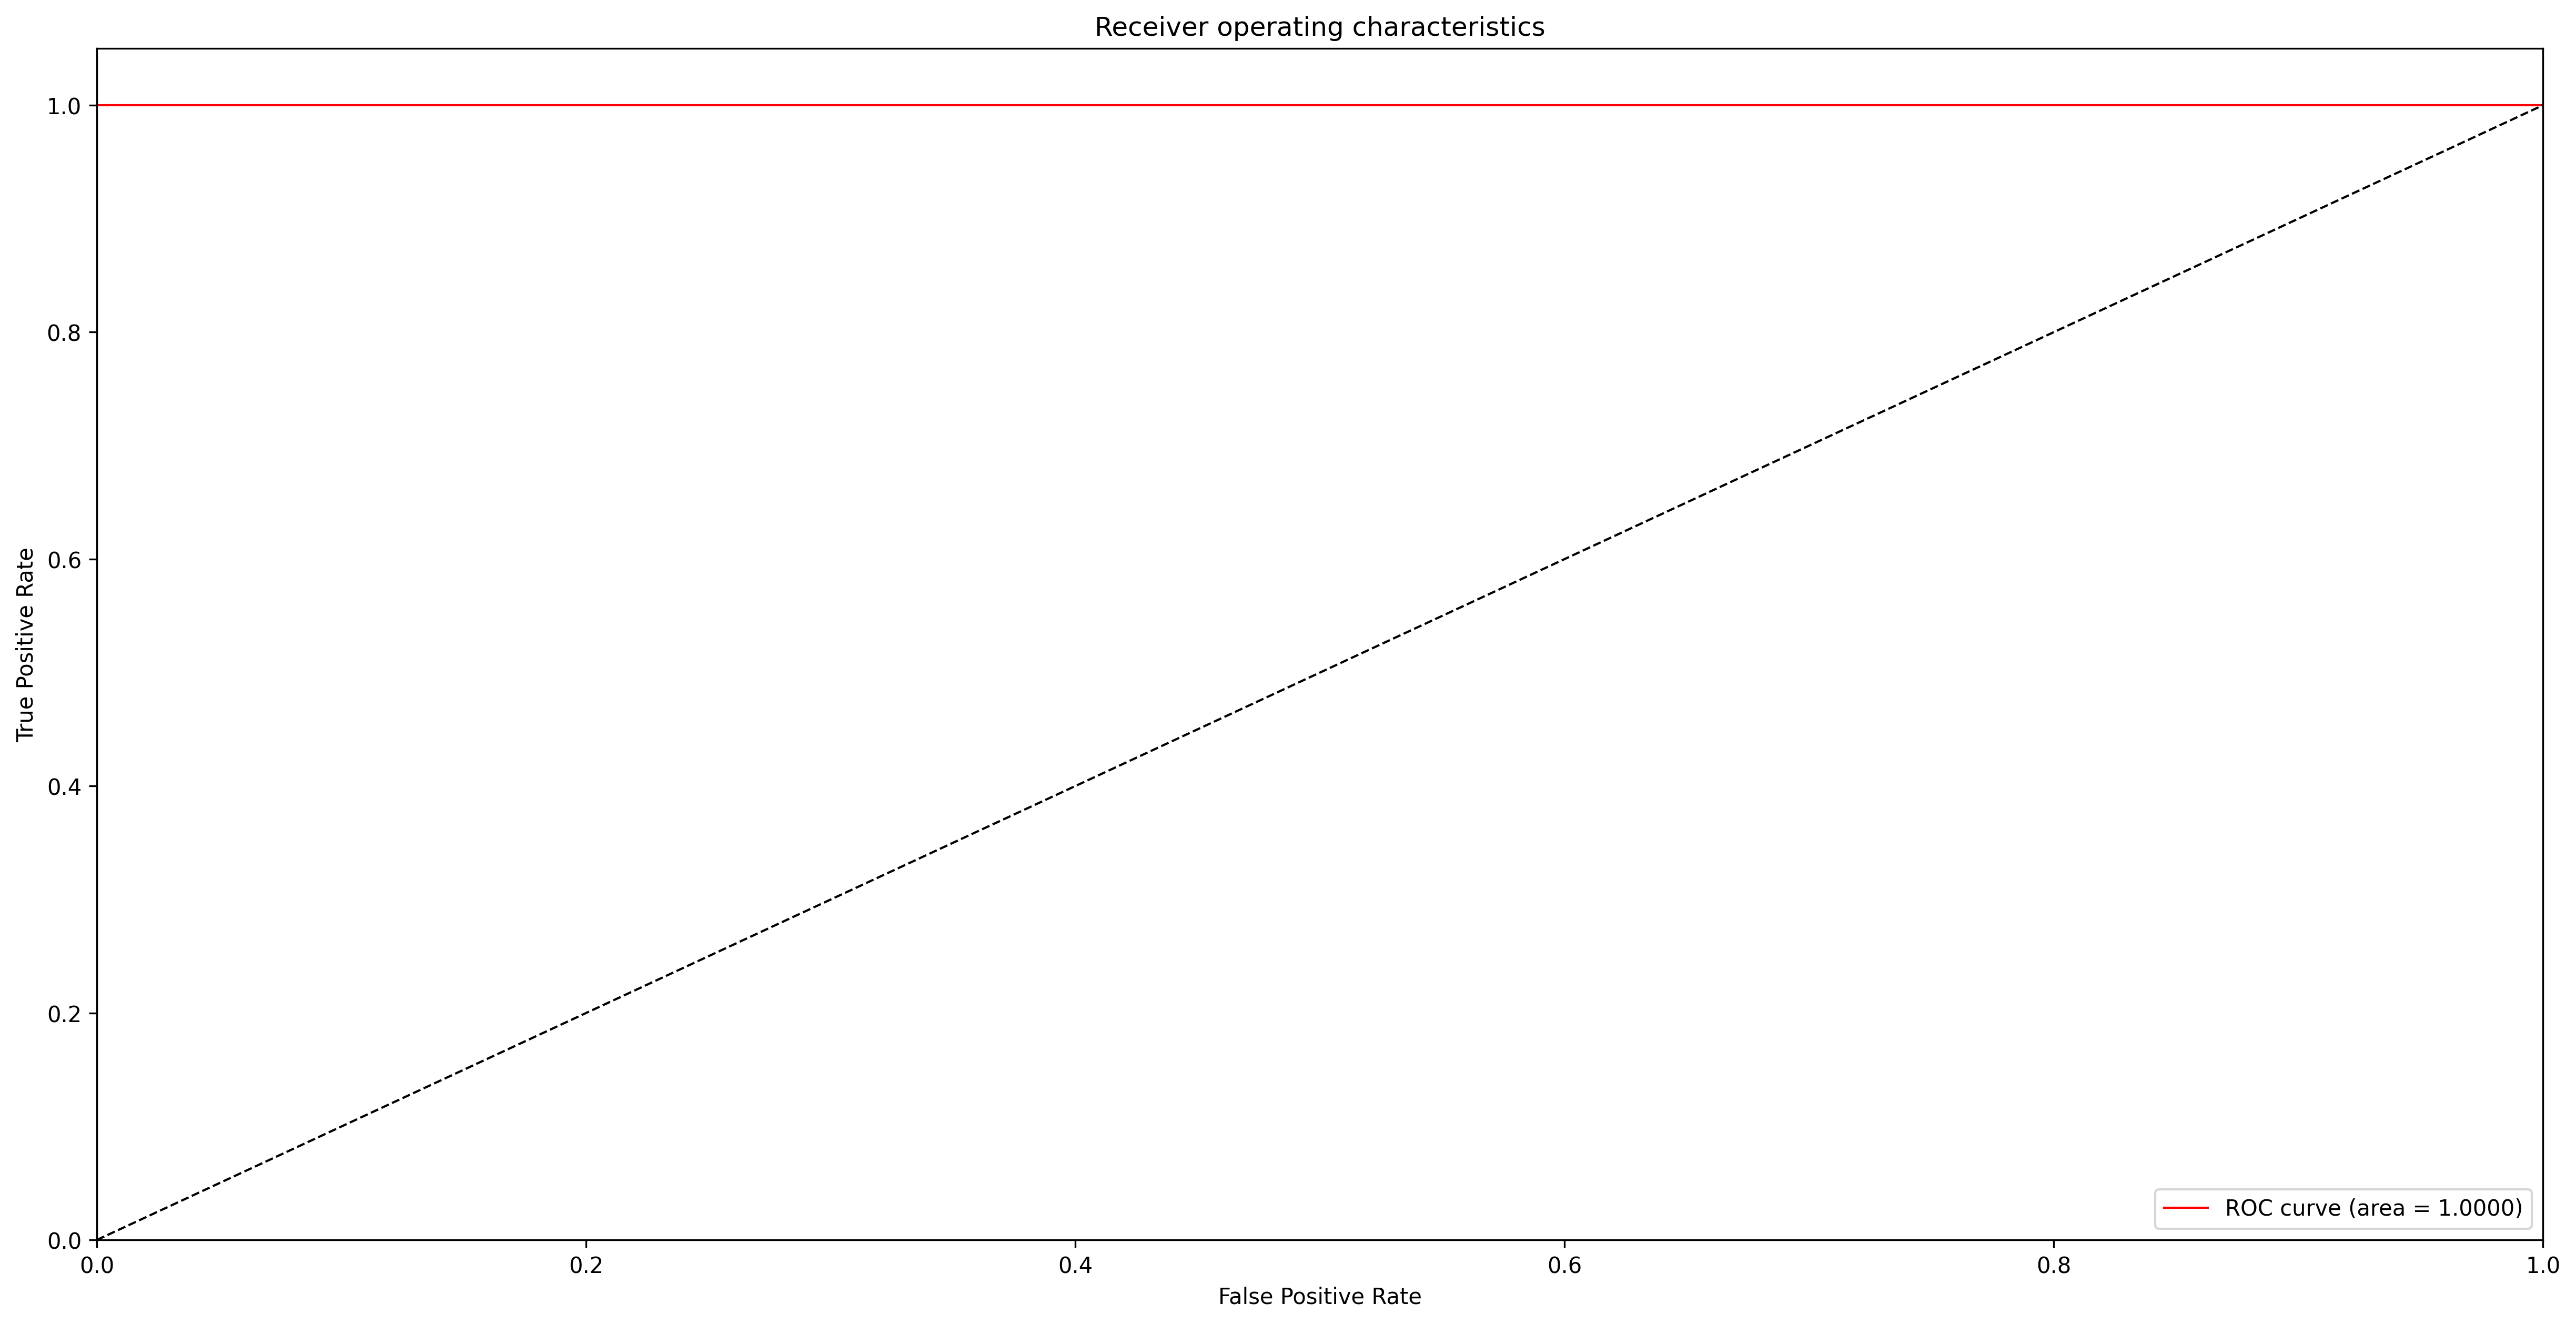

In [ ]:
#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#Plot ROC curve for the positive class
plt.figure(figsize=(20,10), dpi=300)
lw = 1 #true class label
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()


In [ ]:
## computhe the cross-entropy loss score
score = log_loss(Y_test,y_pred)
print("cross-entropy loss score : ", score)

## compute the average precision score
prec_score = average_precision_score(Y_test,y_pred)  
print("average precision score : ", prec_score)

# transfer it back
y_pred_arg = np.argmax(y_pred, axis=1)
Y_test_arg = np.argmax(Y_test, axis=1)
print(y_pred_arg)
print(Y_test_arg)

np.savetxt('custom_model_y_pred.csv',y_pred_arg,fmt='%i',delimiter = ",")
np.savetxt('custom_model_Y_val.csv',Y_test_arg,fmt='%i',delimiter = ",")

cross-entropy loss score :  0.0018997316072585828
average precision score :  1.0
[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]


                   precision    recall  f1-score   support

class 0(abnormal)       1.00      1.00      1.00      2726
  class 1(normal)       1.00      1.00      1.00      2786

         accuracy                           1.00      5512
        macro avg       1.00      1.00      1.00      5512
     weighted avg       1.00      1.00      1.00      5512

[[2726    0]
 [   0 2786]]
Confusion matrix, without normalization
[[2726    0]
 [   0 2786]]


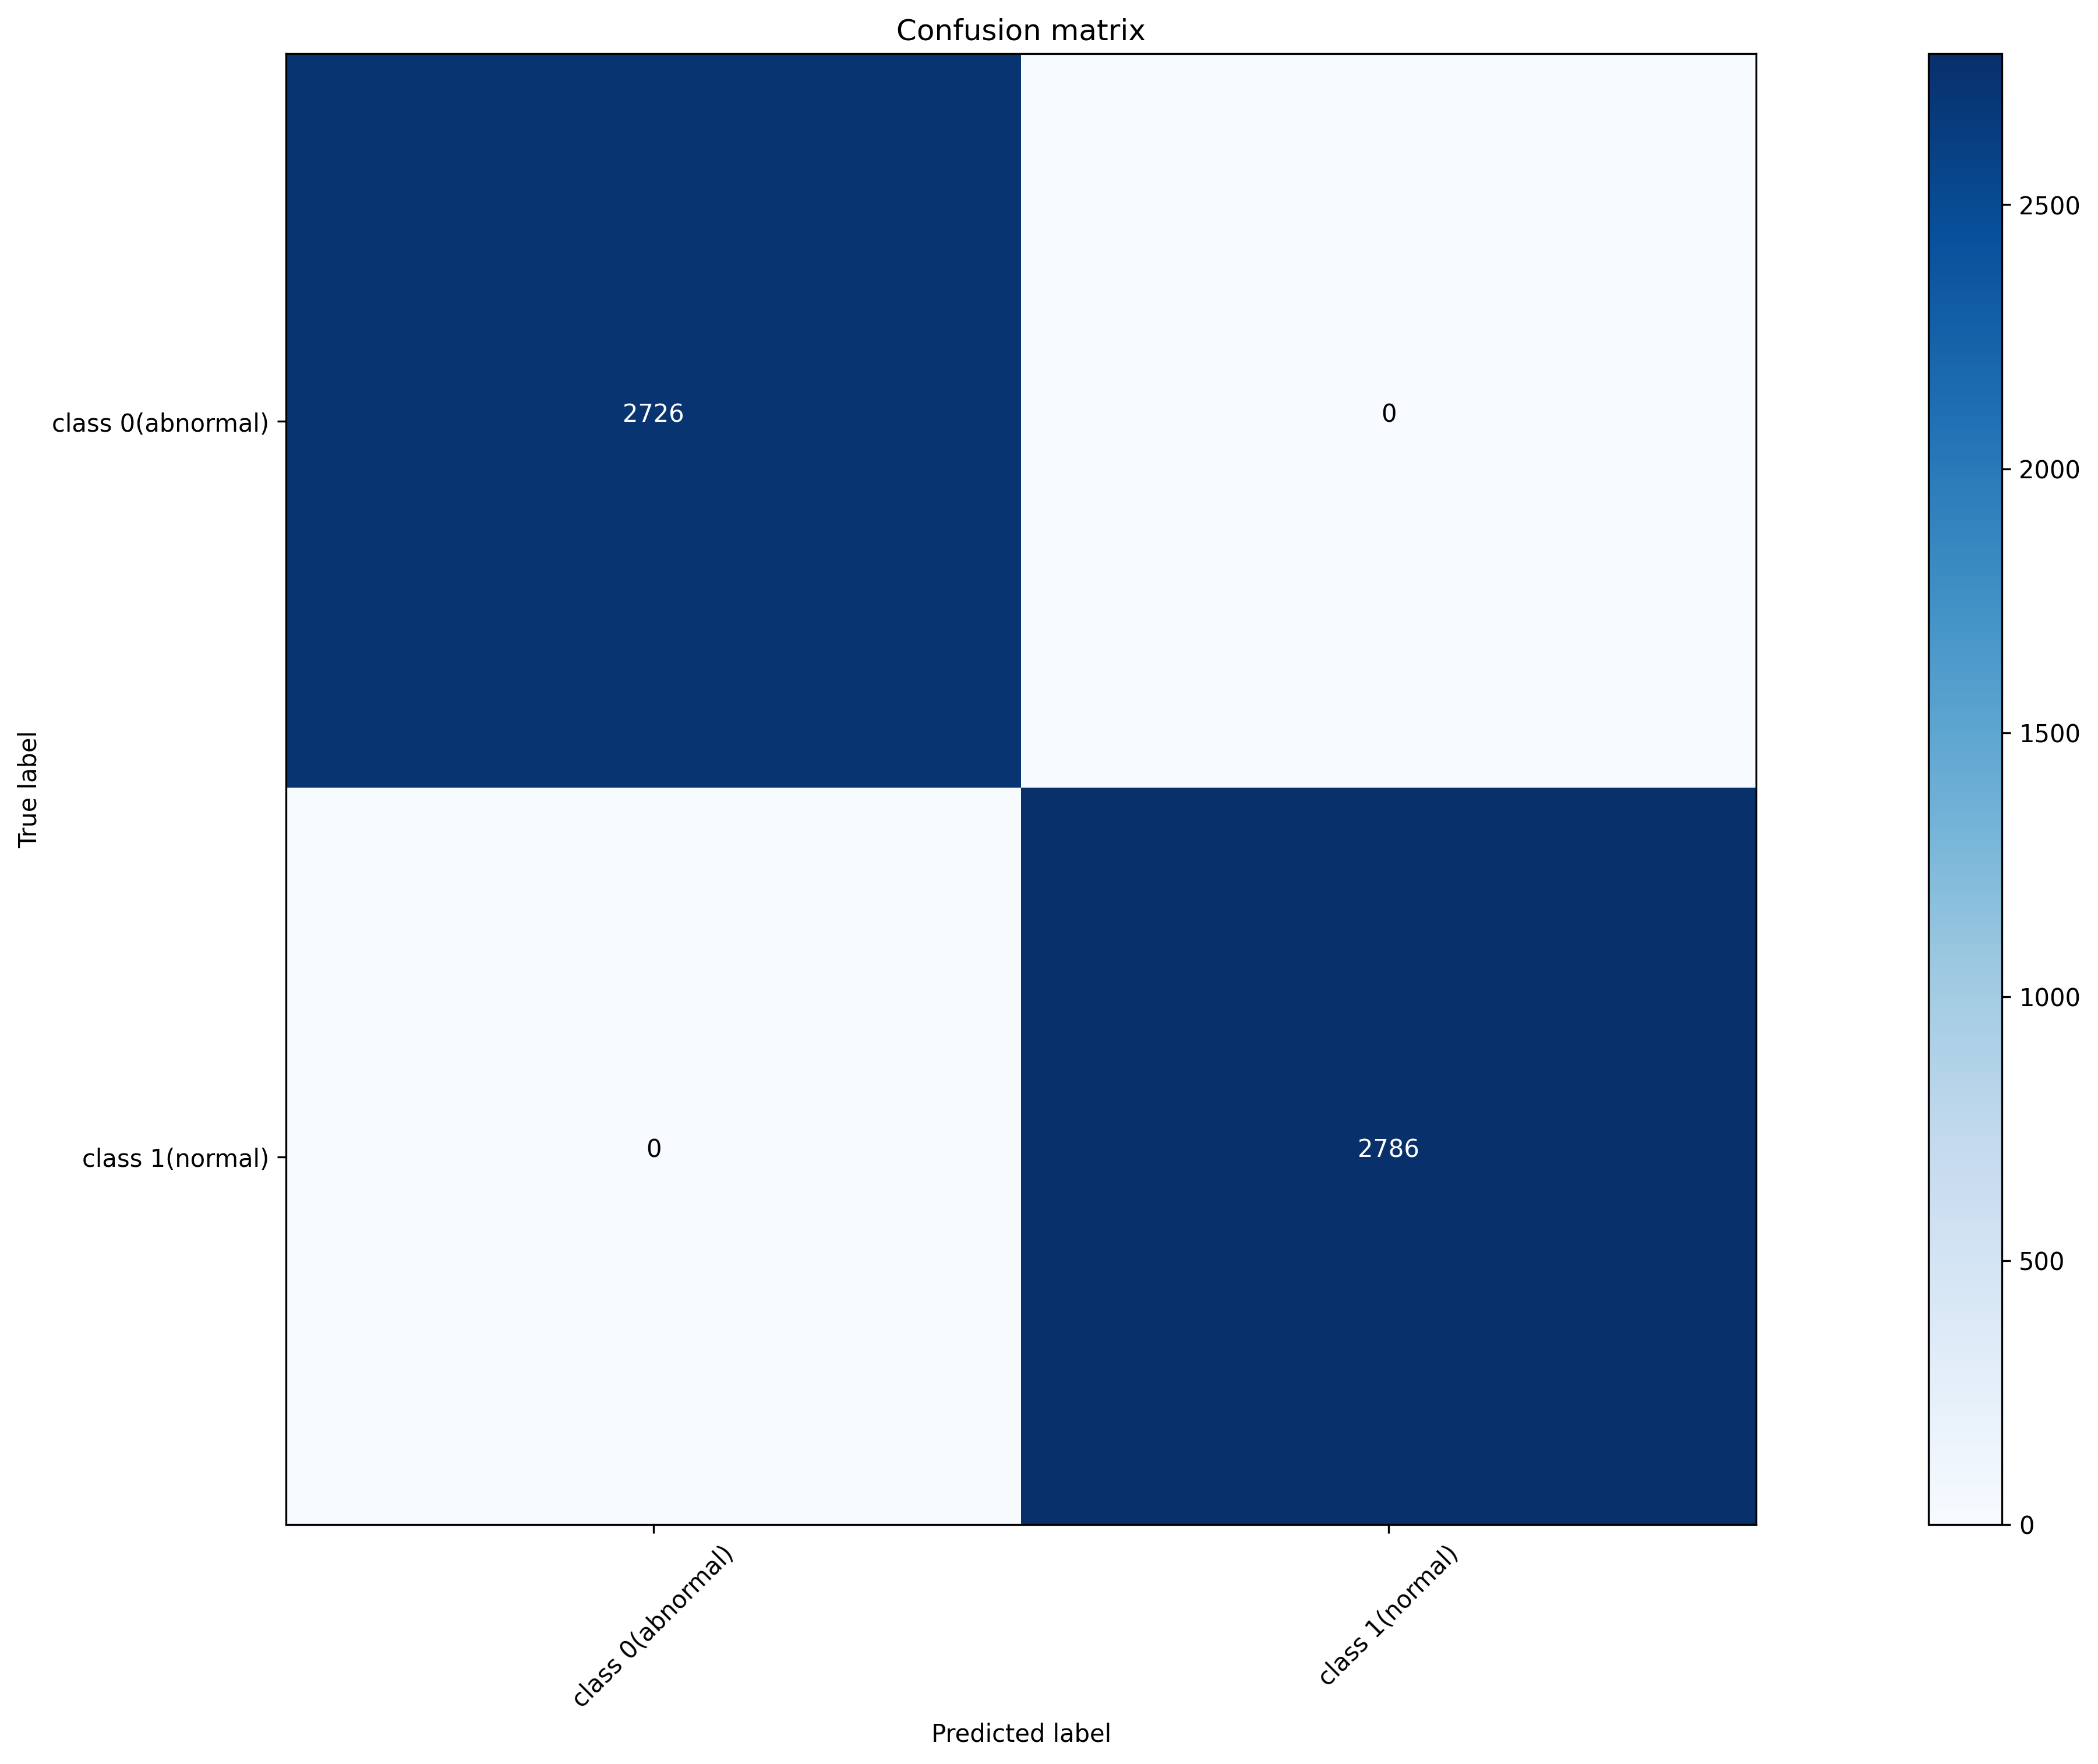

In [ ]:
#################compute confusion matrix######################################

#plot the confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)']
print(classification_report(Y_test_arg,y_pred_arg,target_names=target_names))
print(confusion_matrix(Y_test_arg,y_pred_arg))
cnf_matrix = (confusion_matrix(Y_test_arg,y_pred_arg))
np.set_printoptions(precision=4)
plt.figure(figsize=(20,10), dpi=300)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names,
                  title='Confusion matrix')
plt.show()

In [ ]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

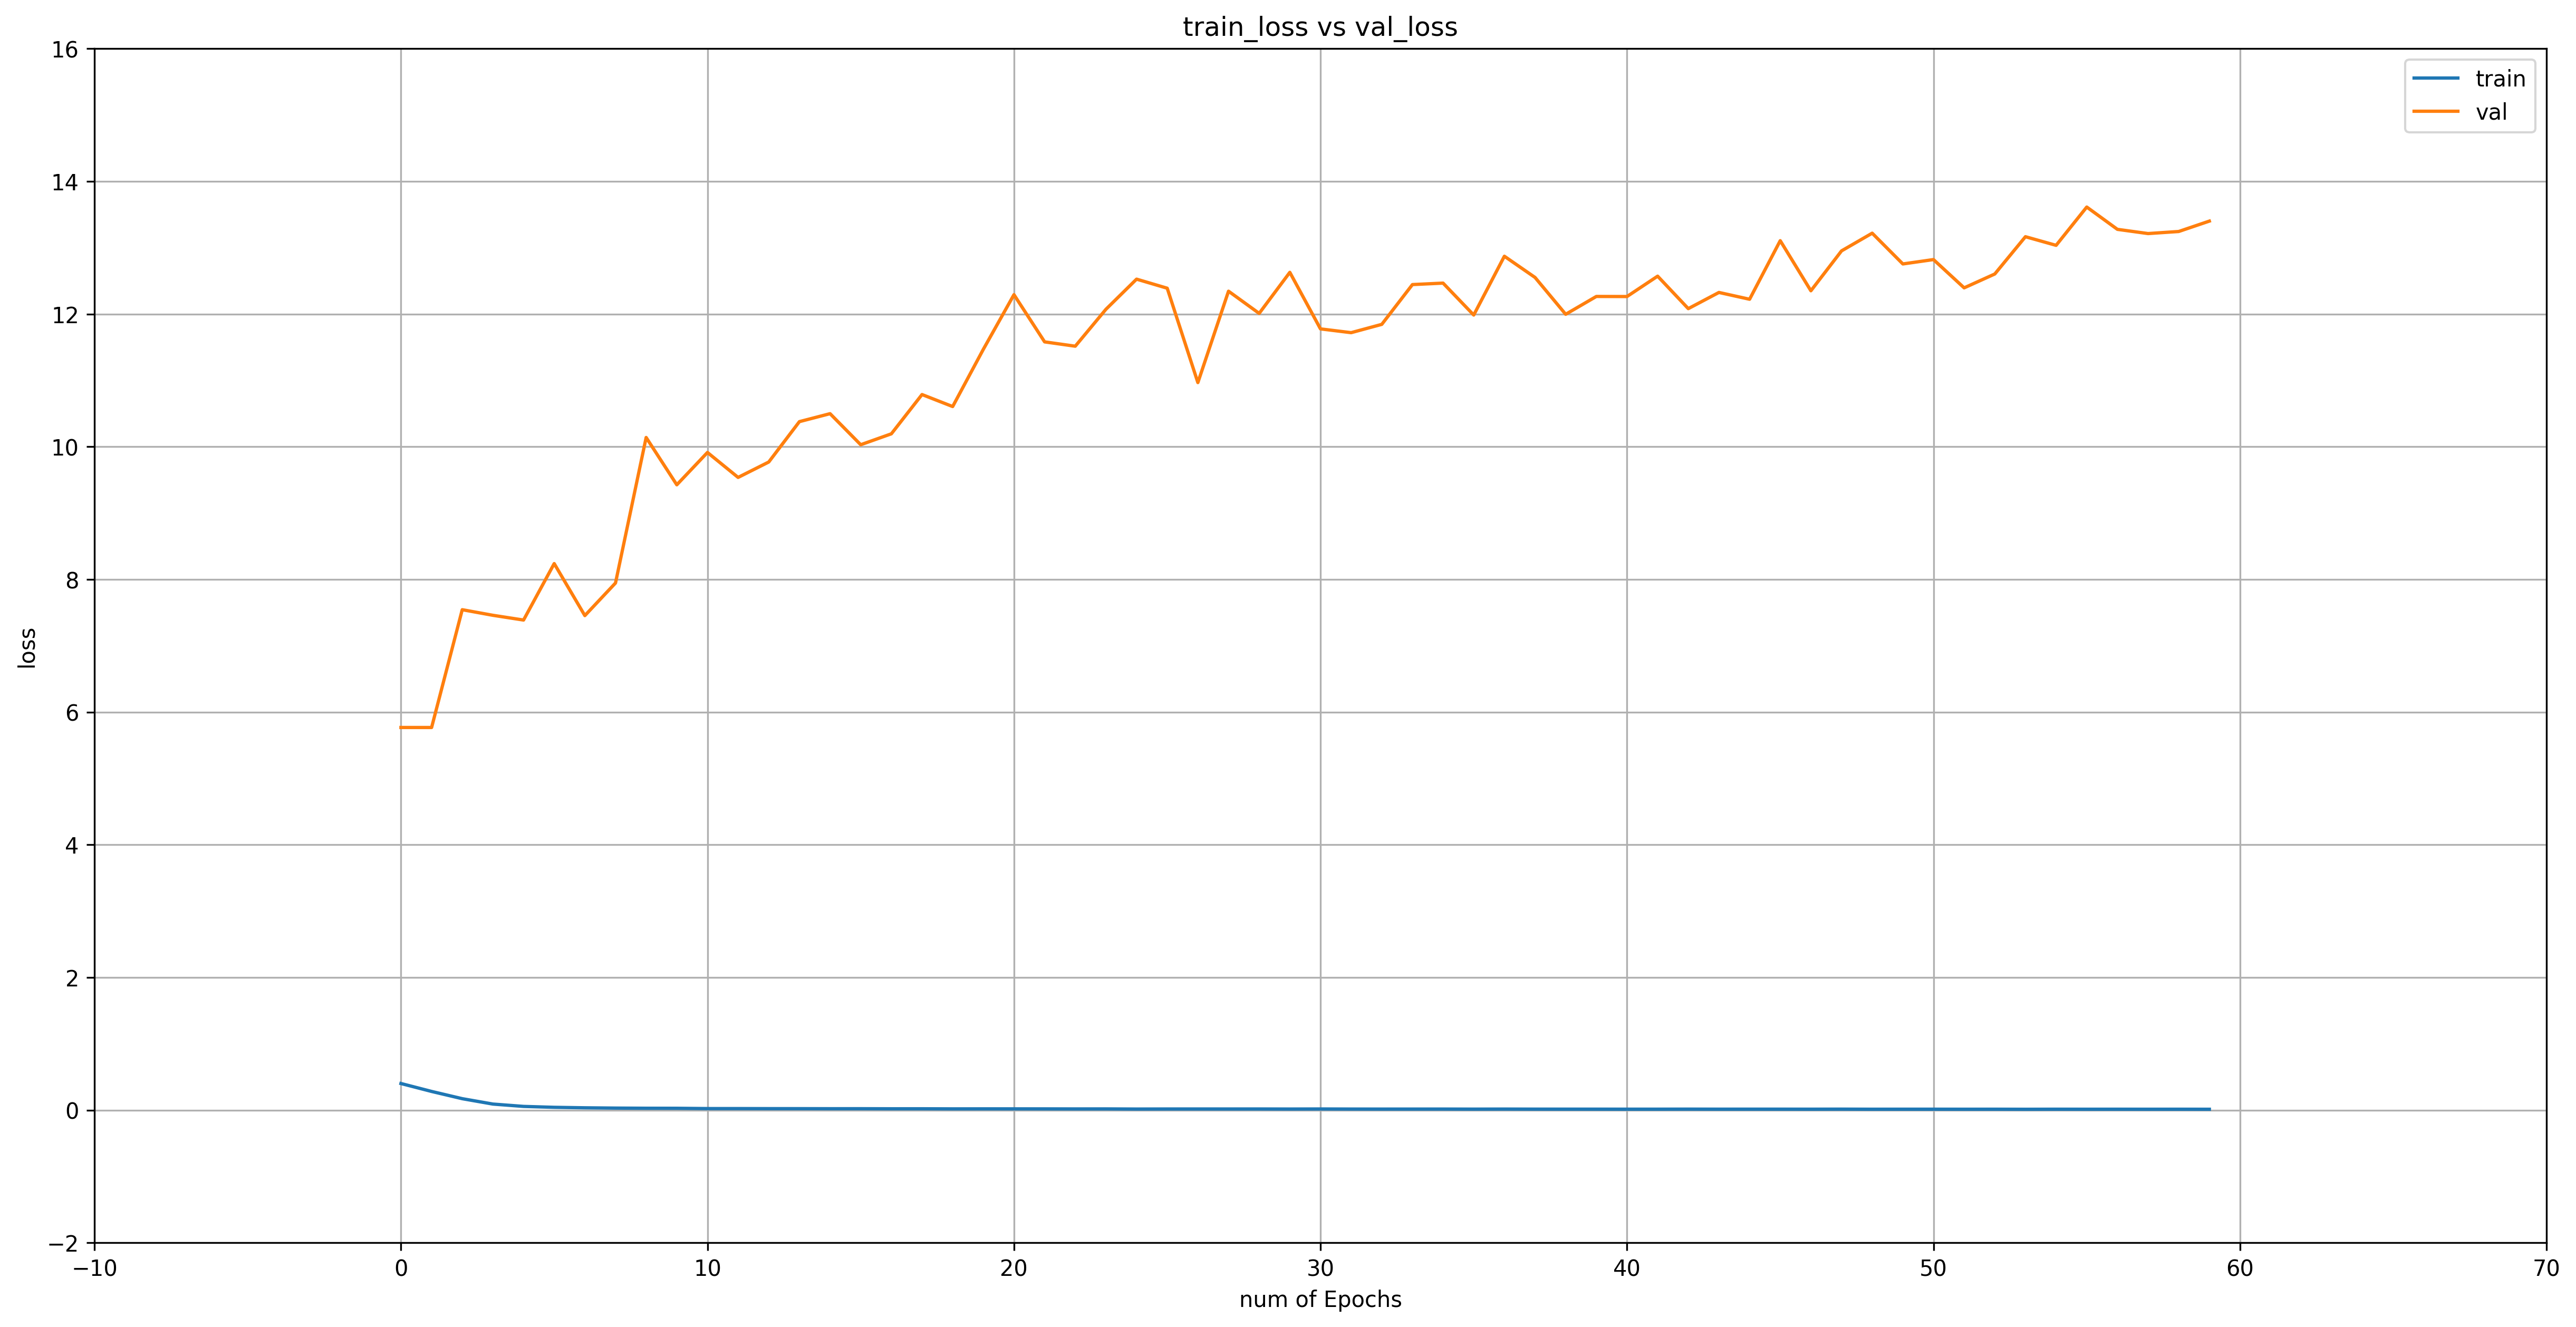

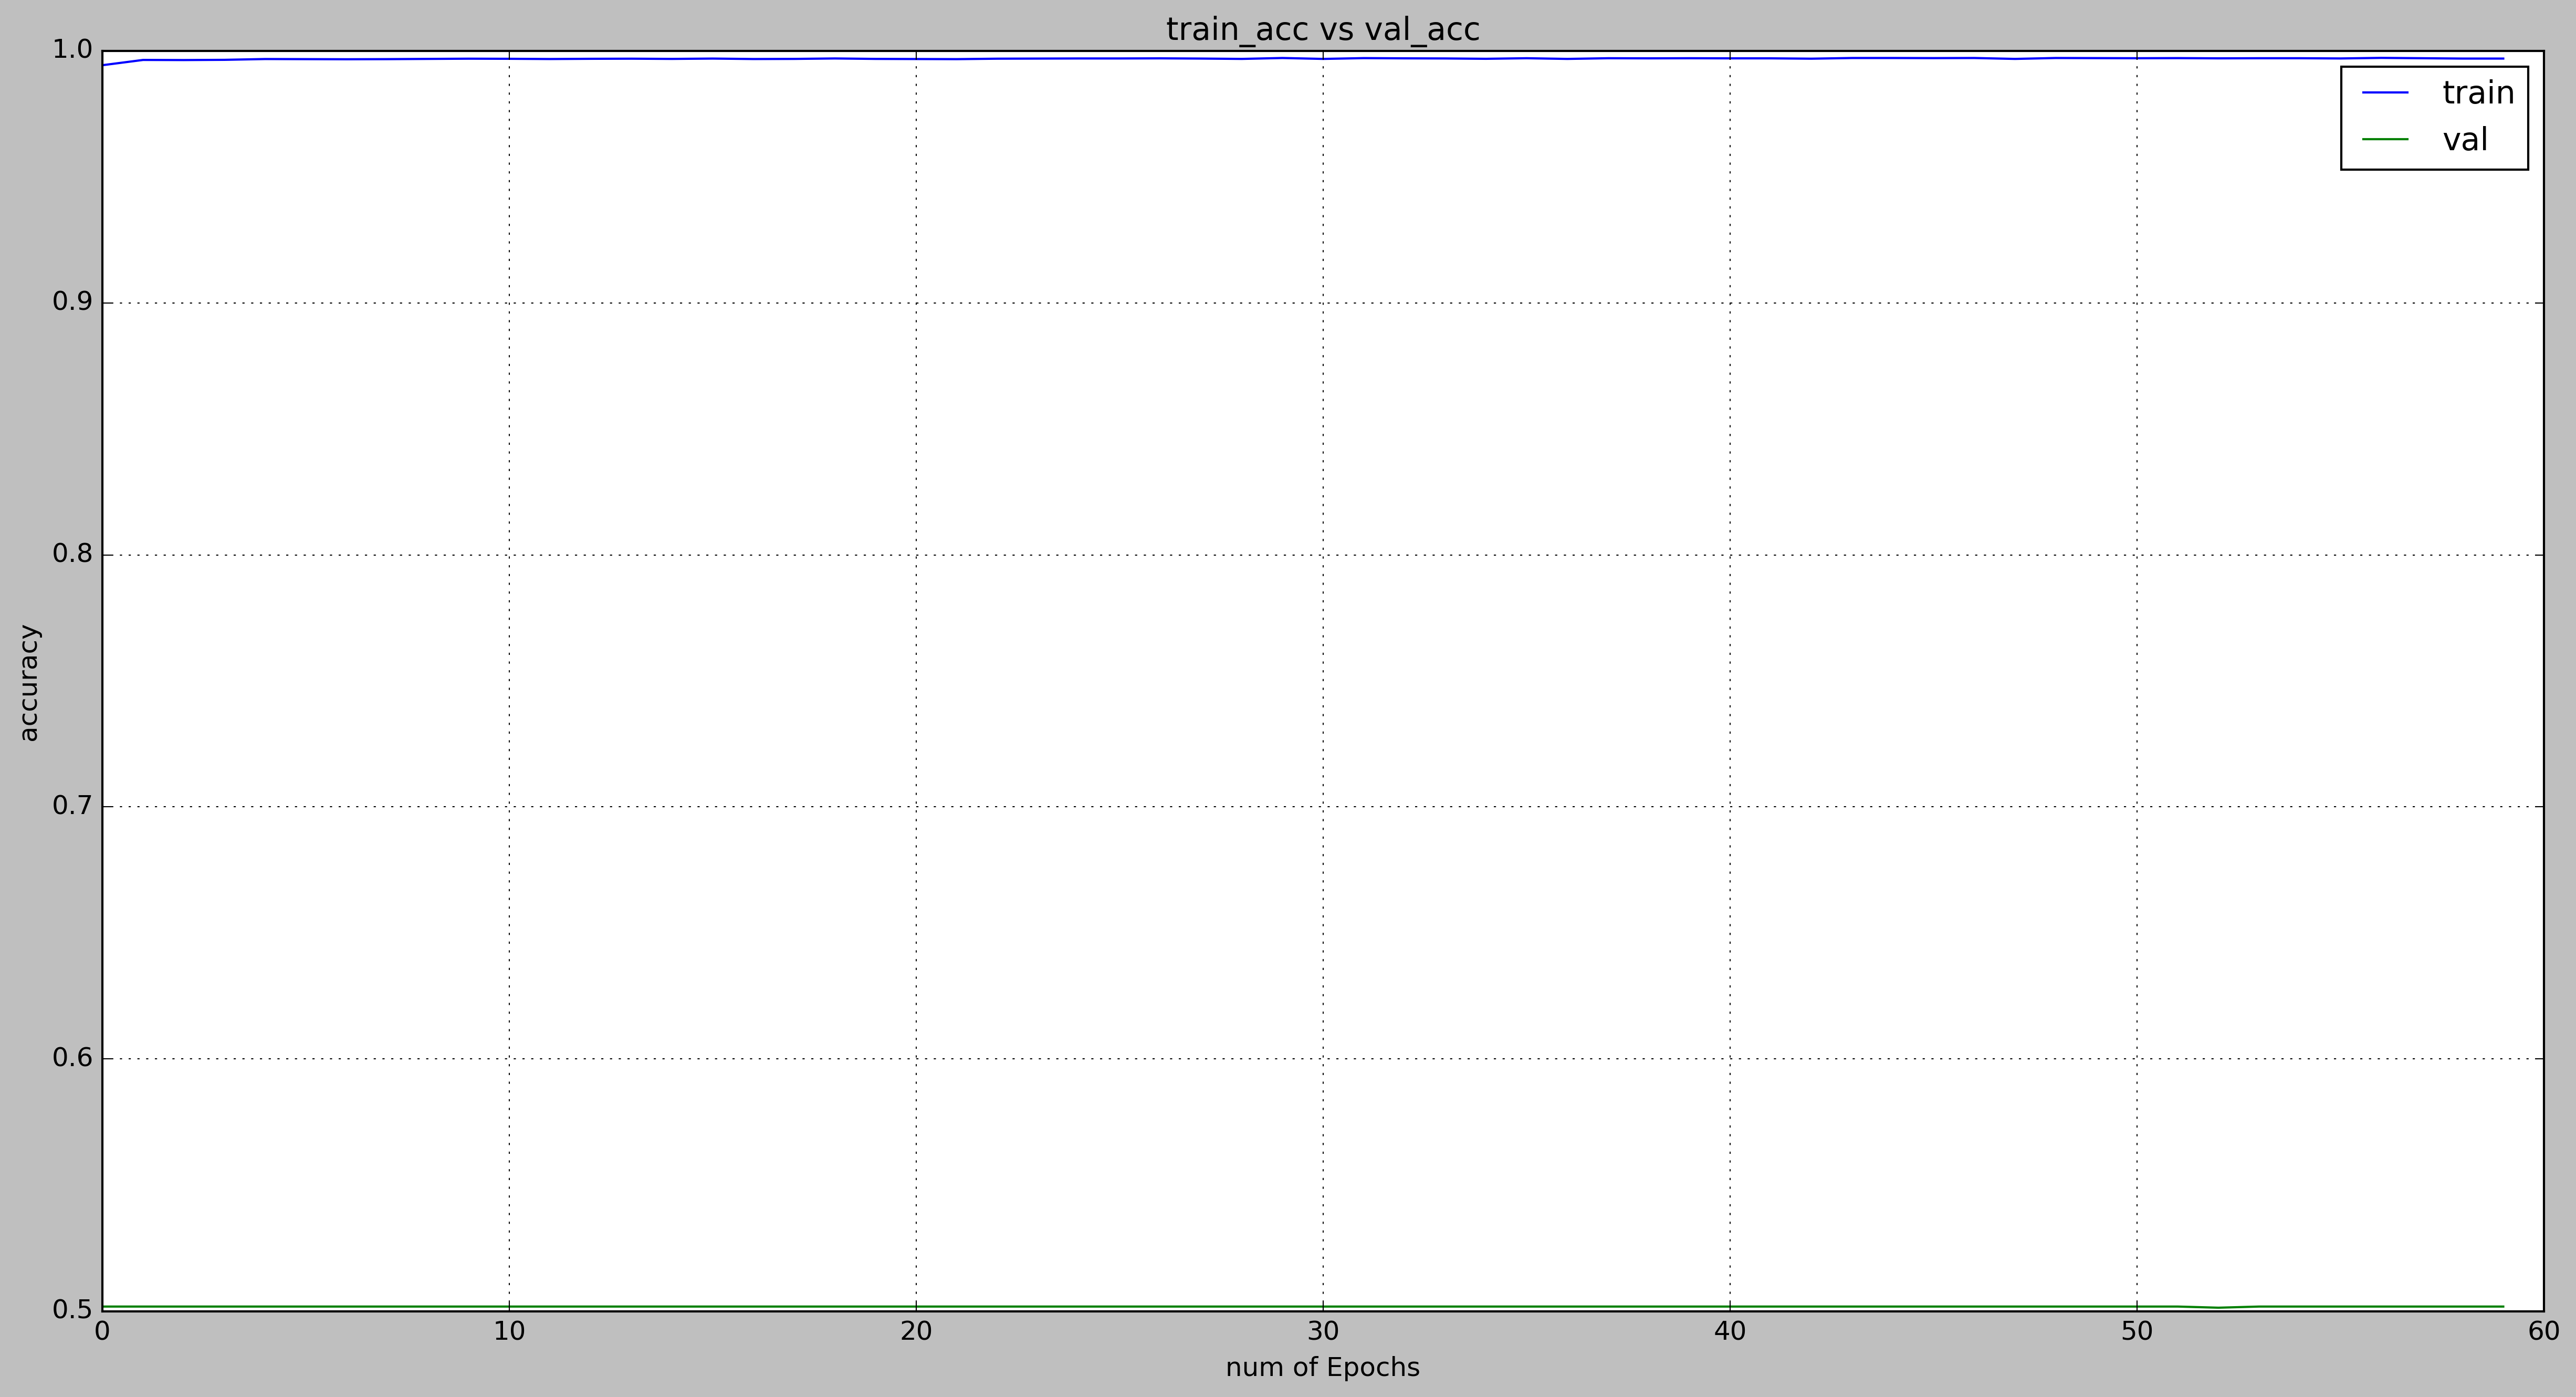

In [ ]:
###############################################################################
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(num_epoch)

plt.figure(1,figsize=(20,10), dpi=300)
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(20,10), dpi=300)
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'])
#plt.style.use(['classic'])
plt.style.use(['classic'])
###############################################################################

## densenet121_models.py

In [ ]:
#This is the root model for DenseNet-121

from keras.optimizers import SGD
from keras.layers import Input, merge, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import keras.backend as K

# from custom_layers.scale_layer import Scale

def densenet121_model(img_rows, img_cols, color_type=1, nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.5, dropout_rate=0.0, weight_decay=1e-4, num_classes=None):
    '''
    DenseNet 121 Model for Keras

    Model Schema is based on 
    https://github.com/flyyufelix/DenseNet-Keras

    ImageNet Pretrained Weights 
    Theano: https://drive.google.com/open?id=0Byy2AcGyEVxfMlRYb3YzV210VzQ
    TensorFlow: https://drive.google.com/open?id=0Byy2AcGyEVxfSTA4SHJVOHNuTXc

    # Arguments
        nb_dense_block: number of dense blocks to add to end
        growth_rate: number of filters to add per dense block
        nb_filter: initial number of filters
        reduction: reduction factor of transition blocks.
        dropout_rate: dropout rate
        weight_decay: weight decay factor
        classes: optional number of classes to classify images
        weights_path: path to pre-trained weights
    # Returns
        A Keras model instance.
    '''
    eps = 1.1e-5

    # compute compression factor
    compression = 1.0 - reduction

    # Handle Dimension Ordering for different backends
    global concat_axis
    if K.image_dim_ordering() == 'tf':
      concat_axis = 3
      img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
    else:
      concat_axis = 1
      img_input = Input(shape=(color_type, img_rows, img_cols), name='data')

    # From architecture for ImageNet (Table 1 in the paper)
    nb_filter = 64
    nb_layers = [6,12,24,16] # For DenseNet-121

    # Initial convolution
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Convolution2D(nb_filter, 7, 7, subsample=(2, 2), name='conv1', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
    x = Scale(axis=concat_axis, name='conv1_scale')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx+2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

        # Add transition_block
        x = transition_block(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate, weight_decay=weight_decay)
        nb_filter = int(nb_filter * compression)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv'+str(final_stage)+'_blk_bn')(x)
    x = Scale(axis=concat_axis, name='conv'+str(final_stage)+'_blk_scale')(x)
    x = Activation('relu', name='relu'+str(final_stage)+'_blk')(x)

    x_fc = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)
    x_fc = Dense(1000, name='fc6')(x_fc)
    x_fc = Activation('softmax', name='prob')(x_fc)

    model = Model(img_input, x_fc, name='densenet')

    if K.image_dim_ordering() == 'th':
      # Use pre-trained weights for Theano backend
      weights_path = 'densenet121_weights_th.h5'
    else:
      # Use pre-trained weights for Tensorflow backend
      weights_path = 'densenet121_weights_tf.h5'

    model.load_weights(weights_path, by_name=True)

    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)
    x_newfc = Dense(num_classes, name='fc6')(x_newfc)
    x_newfc = Activation('softmax', name='prob')(x_newfc)

    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    

    #model = Model(img_input, x)
    return model


def conv_block(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):
    '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout
        # Arguments
            x: input tensor 
            stage: index for dense block
            branch: layer index within each dense block
            nb_filter: number of filters
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''
    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_' + str(branch)
    relu_name_base = 'relu' + str(stage) + '_' + str(branch)

    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4  
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x1_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x1_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x1')(x)
    x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x2_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x2_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x2')(x)
    x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
    x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_x2', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


def transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
    ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout 
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_filter: number of filters
            compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''

    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_blk'
    relu_name_base = 'relu' + str(stage) + '_blk'
    pool_name_base = 'pool' + str(stage) 

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_scale')(x)
    x = Activation('relu', name=relu_name_base)(x)
    x = Convolution2D(int(nb_filter * compression), 1, 1, name=conv_name_base, bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)

    return x


def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_layers: the number of layers of conv_block to append to the model.
            nb_filter: number of filters
            growth_rate: growth rate
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            grow_nb_filters: flag to decide to allow number of filters to grow
    '''

    eps = 1.1e-5
    concat_feat = x

    for i in range(nb_layers):
        branch = i+1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
        concat_feat = merge([concat_feat, x], mode='concat', concat_axis=concat_axis, name='concat_'+str(stage)+'_'+str(branch))

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter


## googlenet_custom_layers.py

In [ ]:
"""Custom Keras layers for GoogLeNet"""

from keras.layers.core import Layer
from keras.engine import InputSpec
from keras import backend as K
import theano.tensor as T
try:
    from keras import initializations
except ImportError:
    from keras import initializers as initializations

class LRN(Layer):
    """
    Custom Layer for Local Response Normalization (LRN)
    """

    def __init__(self, alpha=0.0001,k=1,beta=0.75,n=5, **kwargs):
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n
        super(LRN, self).__init__(**kwargs)
    
    def call(self, x, mask=None):
        b, ch, r, c = x.shape
        half_n = self.n // 2 # half the local region
        input_sqr = T.sqr(x) # square the input
        extra_channels = T.alloc(0., b, ch + 2*half_n, r, c) # make an empty tensor with zero pads along channel dimension
        input_sqr = T.set_subtensor(extra_channels[:, half_n:half_n+ch, :, :],input_sqr) # set the center to be the squared input
        scale = self.k # offset for the scale
        norm_alpha = self.alpha / self.n # normalized alpha
        for i in range(self.n):
            scale += norm_alpha * input_sqr[:, i:i+ch, :, :]
        scale = scale ** self.beta
        x = x / scale
        return x

    def get_config(self):
        config = {"alpha": self.alpha,
                  "k": self.k,
                  "beta": self.beta,
                  "n": self.n}
        base_config = super(LRN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class PoolHelper(Layer):
    """
    Reconcile Keras and Caffe weights
    """

    def __init__(self, **kwargs):
        super(PoolHelper, self).__init__(**kwargs)
    
    def call(self, x, mask=None):
        return x[:,:,1:,1:]
    
    def get_config(self):
        config = {}
        base_config = super(PoolHelper, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


## feature_extraction.py

In [ ]:
########################load libraries#########################################
import time
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras import applications
from keras.optimizers import SGD
# from load_data import load_resized_training_data, load_resized_validation_data
from sklearn.metrics import log_loss
import numpy as np
# from densenet121_models import densenet121_model 
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
# from evaluation import plot_confusion_matrix
from sklearn.metrics import average_precision_score
#########################image characteristics#################################
img_rows=100 #dimensions of image
img_cols=100
channel = 3 #RGB
num_classes = 2 
batch_size = 1 #vary depending on the GPU
num_epoch = 60
###############################################################################
''' This code uses VGG-16 as a feature extractor'''

# create the base pre-trained model
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(100,100,3))

''' you can use the rest of the models like:
feature_model = applications.ResNet50((weights='imagenet', include_top=False, input_shape=(224,224,3)) 
feature_model = applications.Xception((weights='imagenet', include_top=False, input_shape=(100,100,3))
For DenseNet, the main file densenet121_model is included to this repository.
The model can be used as :
feature_model = densenet121_model(img_rows=img_rows, img_cols=img_cols, color_type=channel, num_classes=num_classes)
'''
#extract feature from an intermediate layer
base_model = Model(input=base_model.input, output=base_model.get_layer('block5_conv2').output) 

''' you can use the rest of the models like this:
feature_model = Model(input=feature_model.input, output=feature_model.get_layer('res5c_branch2c').output) #for ResNet50
feature_model = Model(input=feature_model.input, output=feature_model.get_layer('block14_sepconv1').output) #for Xception'''

#get the model summary
base_model.summary()
###############################################################################
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer 
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
###############################################################################
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers to prevent large gradient updates wrecking the learned weights
for layer in base_model.layers:
    layer.trainable = False
# compile the model (should be done *after* setting layers to non-trainable)
#fix the optimizer
sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True) 
#compile the gpu model
model.compile(optimizer=sgd,
              loss='mse',
              metrics=['accuracy'])
###############################################################################
#load data for training
X_train, Y_train = load_resized_training_data(img_rows, img_cols)
X_valid, Y_valid = load_resized_validation_data(img_rows, img_cols)
#print the shape of the data
print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
###############################################################################
t=time.time() #make a note of the time
#start training
print('-'*30)
print('Start Training the model...')
print('-'*30)
hist = model.fit(X_train, Y_train,
      batch_size=batch_size,
      epochs=num_epoch,
      shuffle=True,
      validation_data=None,
      verbose=1)

#print the history of the trained model
print(hist.history)

#compute the training time
print('Training time: %s' % (time.time()-t))
###############################################################################
# Make predictions on validation data
print('-'*30)
print('Predicting on validation data...')
print('-'*30)
y_pred = model.predict(X_valid, batch_size=batch_size, verbose=1)
###############################################################################
#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_valid.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#Plot ROC curves
plt.figure(figsize=(15,10), dpi=300)
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

# computhe the cross-entropy loss score
score = log_loss(Y_valid,y_pred)
print(score)

# compute the average precision score
prec_score = average_precision_score(Y_valid,y_pred)  
print(prec_score)

# compute the accuracy on validation data
Test_accuracy = accuracy_score(Y_valid.argmax(axis=-1),y_pred.argmax(axis=-1))
print("Test_Accuracy = ",Test_accuracy)

#declare target names
target_names = ['class 0(abnormal)', 'class 1(normal)'] #it should be normal and abnormal for linux machines

#print classification report
print(classification_report(Y_valid.argmax(axis=-1),y_pred.argmax(axis=-1),target_names=target_names))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_valid.argmax(axis=-1),y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
###############################################################################
# transfer it back
y_pred = np.argmax(y_pred, axis=1)
Y_valid = np.argmax(Y_valid, axis=1)
print(y_pred)
print(Y_valid)

#save the predicted and ground-truth labels.
np.savetxt('malaria_y_pred.csv',y_pred,fmt='%i',delimiter = ",")
np.savetxt('malaria_Y_val.csv',Y_valid,fmt='%i',delimiter = ",")
###############################################################################
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(num_epoch)

plt.figure(1,figsize=(15,10), dpi=300)
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(15,10), dpi=300)
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
plt.style.use(['classic'])
###############################################################################